<a href="https://colab.research.google.com/github/equisdel/brain-tumor-classification/blob/main/Deteccion_Tumores_Cerebrales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detección y Clasificación de Tumores Cerebrales**

En este trabajo se plantea lograr el reconocimiento y la clasificación de *tumores cerebrales* a partir de imágenes por resonancia magnética (MRI). El conjunto de imagenes utilizadas en el trabajo fueron obtenidas del dataset de Kaggles: [Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

Dentro del notebook se plantearan diferentes secciones tales como:
*   Análisis y Normalización del Dataset.
*   Construcción de diferentes modelos de redes neuronales.
*   Entrenamiento y Testeo.
*   Ampliación de dataset (Data Augmentation).
*   Conclusiones.

El objetivo del trabajo es plantear diversos modelos de Redes Neuronales Convolucionales (CNN) y compararlos entre sí, analizando su comportamiento y desempeño en el reconocimiento y clasificación de imágenes. A su vez, se busca mejorar la precisión del mejor modelo obtenido a través del método *Data Augmentation*.



## Importaciones.

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, Sequential, callbacks
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from prettytable import PrettyTable, ALL

#from google.colab import files,drive


# Dataset

### **¿De qué manera accedemos a los datos?**
Para agilizar el proceso de fetching de los datos decidimos almacenar las imágenes en un [repositorio de Github](https://github.com/equisdel/brain-tumor-classification.git) para posteriormente clonarlo en el entorno de Colab y poder acceder a los datos libremente. Una vez ejecutado el código que se encuentra inmediatamente debajo, a la izquierda en _Archivos_ debería figurar la carpeta _brain-tumor-classification_ con las imágenes previamente descritas.

In [6]:
# Clonamos el repositorio de GitHub que contiene al dataset
!git clone https://github.com/equisdel/brain-tumor-classification.git

Cloning into 'brain-tumor-classification'...
remote: Enumerating objects: 6743, done.
remote: Total 6743 (delta 0), reused 0 (delta 0), pack-reused 6743
Receiving objects: 100% (6743/6743), 140.80 MiB | 33.96 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (7024/7024), done.


### **¿De qué datos disponemos?**

A primera vista notamos que el dataset obtenido cuenta con un volúmen considerable de imágenes por resonancia magnética (MRI) previamente repartidas entre dos carpetas: Training y Testing. Asimismo cada imágen se encuentra correctamente clasificada en una categoría/carpeta de las cuatro siguientes:
1. Presenta tumor Glioma.      
2. Presenta tumor Meninglioma.
3. Presenta tumor Pituitario.
4. No presenta tumor. \

Este nivel de detalle en los datos permite no solo detectar la presencia o ausencia de un tumor cerebral en una imagen MRI, sino también identificar el tipo específico de tumor presente.


Ingresamos la direción *path* de las carpetas e imágenes, diferenciando las de testeo de las de entrenamiento. \
Las variables *fnames* son listas que contienen los nombres de cada imagen de las carpetas indicadas.

In [7]:
# Direcciones BASE
base_dir = '/content/brain-tumor-classification'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Direcciones GLIOMA
train_glioma = os.path.join(train_dir, 'glioma')
test_glioma = os.path.join(test_dir, 'glioma')
train_glioma_fnames = os.listdir(train_glioma)
test_glioma_fnames = os.listdir(test_glioma)

# Direcciones MENINGIOMA
train_meningioma = os.path.join(train_dir, 'meningioma')
test_meningioma = os.path.join(test_dir, 'meningioma')
train_meningioma_fnames = os.listdir(train_meningioma)
test_meningioma_fnames = os.listdir(test_meningioma)

# Direcciones PITUITARY
train_pituitary = os.path.join(train_dir, 'pituitary')
test_pituitary = os.path.join(test_dir, 'pituitary')
train_pituitary_fnames = os.listdir(train_pituitary)
test_pituitary_fnames = os.listdir(test_pituitary)

# Direcciones NO TUMOR
train_notumor = os.path.join(train_dir, 'notumor')
test_notumor = os.path.join(test_dir, 'notumor')
train_notumor_fnames = os.listdir(train_notumor)
test_notumor_fnames = os.listdir(test_notumor)


### **¿De cuántos datos disponemos?**

In [ ]:
# Cantidad de imágenes en Training
cant_train_glioma = len(train_glioma_fnames)
cant_train_meningioma = len(train_meningioma_fnames)
cant_train_pituitary = len(train_pituitary_fnames)
cant_train_no_tumor = len(train_notumor_fnames)
# Cantidad de imágenes en Testing
cant_test_glioma = len(test_glioma_fnames)
cant_test_meningioma = len(test_meningioma_fnames)
cant_test_pituitary = len(test_pituitary_fnames)
cant_test_no_tumor = len(test_notumor_fnames)
# Imágenes totales
total_train = cant_train_glioma + cant_train_meningioma + cant_train_pituitary + cant_train_no_tumor
total_test = cant_test_glioma + cant_test_meningioma + cant_test_pituitary + cant_test_no_tumor
total_glioma = cant_train_glioma + cant_test_glioma
total_meningioma = cant_train_meningioma + cant_test_meningioma
total_pituitary = cant_train_pituitary + cant_test_pituitary
total_no_tumor = cant_train_no_tumor + cant_test_no_tumor
total = total_train + total_test

# Mostrar la información en una tabla
table = PrettyTable()
table.field_names = ['#IMAGENES','Glioma','Meningioma','Pituitario','No Tumor','TOTAL']
table.add_rows(
    [
        ["Training",cant_train_glioma,cant_train_meningioma,cant_train_pituitary,cant_train_no_tumor,total_train],
        ["Testing",cant_test_glioma,cant_test_meningioma,cant_test_pituitary,cant_test_no_tumor,total_test],
        ["TOTAL",total_glioma,total_meningioma,total_pituitary,total_no_tumor,total]
    ]
)
table.hrules = ALL
table.border = True
print(table)

+-----------+--------+------------+------------+----------+-------+
| #IMAGENES | Glioma | Meningioma | Pituitario | No Tumor | TOTAL |
+-----------+--------+------------+------------+----------+-------+
|  Training |  1321  |    1339    |    1457    |   1595   |  5712 |
+-----------+--------+------------+------------+----------+-------+
|  Testing  |  300   |    306     |    300     |   405    |  1311 |
+-----------+--------+------------+------------+----------+-------+
|   TOTAL   |  1621  |    1645    |    1757    |   2000   |  7023 |
+-----------+--------+------------+------------+----------+-------+


El tamaño total - en cantidad de datos - del dataset es de 7023 imágenes MRI distribuidas entre Training y Testing con una proporción de 81.33% y 18.67% respectivamente. Del total de imágenes, la distribución para cada categoría en orden ascendente es: Glioma (23.09%), Meningioma (23.42%), Pituitario (25.02%), No Tumor (28.47%). Afortunadamente la distribución es lo suficientemente equitativa para las cuatro categorías presentes, por lo que se reduce la posibilidad de que ocurran problemas por desbalanceo de clases (Ejemplo: sesgos).

### **¿En qué formato se encuentran?**

Analizando las propiedades de algunas imágenes notamos que:
- Todas las imágenes se encuentran en formato JPG.
- Todas las imágenes tienen una dimensión de 512 x 512 píxeles con una resolución de 96 ppp (píxeles por pulgada).
- Algunas imágenes se encuentran expresadas en formato RGB mientras que otras están expresadas en escala de grises. Es importante corregir esto para evitar problemas en el entrenamiento de los modelos, por lo que parte del pre-procesamiento será pasar todas las imágenes a un único formato.

El código siguiente permite visualizar para cada categoría algunas de las imágenes de entrenamiento en un tamaño de 8x8 pulgadas.

In [ ]:
def visualizar_imagenes(title, dir_base, dir_fnames, cantidad):
  fig = plt.gcf()
  fig.set_size_inches(8,8)
  fig.suptitle(title,fontsize=16, y=0.96)
  for i in range(cantidad):
    ax = plt.subplot(4, 4, i + 1)
    label = dir_fnames[i]
    path_img = os.path.join(dir_base, label)
    img = mpimg.imread(path_img)
    if (len(img.shape)==3):   # (512, 512, 3): RGB
      label = label + '- RGB'
    else:             # (512, 512): escala de grises
      label = label + ' - GRAY'
    plt.imshow(img, cmap = 'gray', label = label)
    ax.set_title(label, fontsize=8)
    ax.axis('off')

  plt.show()

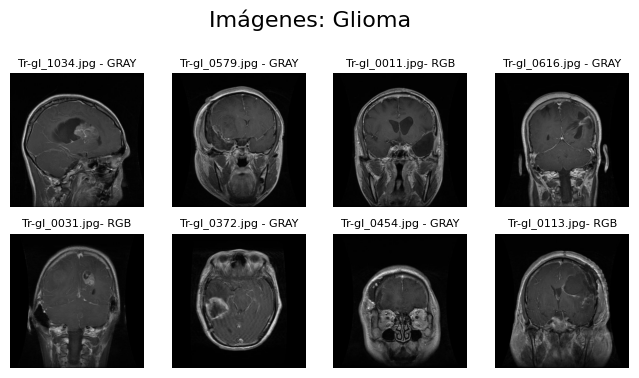

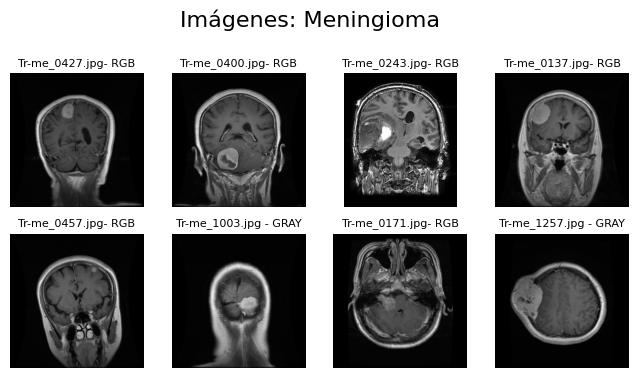

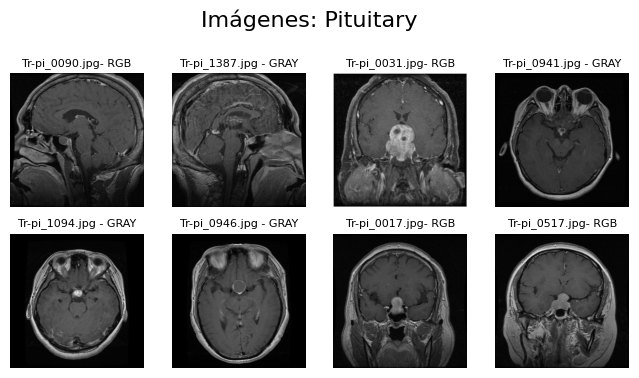

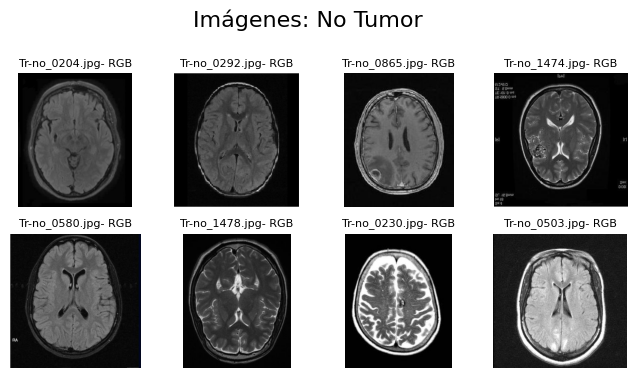

In [ ]:
visualizar_imagenes("Imágenes: Glioma", train_glioma, train_glioma_fnames, 8)
print()
visualizar_imagenes("Imágenes: Meningioma",train_meningioma,train_meningioma_fnames, 8)
print()
visualizar_imagenes("Imágenes: Pituitary",train_pituitary,train_pituitary_fnames, 8)
print()
visualizar_imagenes("Imágenes: No Tumor",train_notumor,train_notumor_fnames, 8)


# Pre-procesamiento de los datos

### **RGB vs. Escala de Grises**
Como mencionamos anteriormente, debemos pasar las imágenes a un único formato (RGB o Escala de Grises). \
En este punto nos surgió la duda: ¿qué conviene? Por un lado, la escala de grises tiene la ventaja de reducir el tamaño de los datos en un tercio por el hecho de tener un único canal destinado al color - en contraposición a los tres canales de RGB - . Esto se traduce en entrenamientos más veloces. La desventaja de optar por escala de grises es la pérdida de información, que podría conducir a pérdida en la precisión de los modelos. \
Para resolver la cuestión nos pareció interesante probar ambas alternativas en modelos que - por lo demás - son idénticos a fin de comprobar cuál de las dos arroja mejores resultados en general.

### **Normalización**

La normalización es una técnica de pre-procesamiento de datos que se utiliza para ajustar las características o atributos de los datos dentro de un rango específico. En nuestro caso, buscamos normalizar el valor de los píxeles de las imágenes del dataset a la escala [0,1]. Esta práctica es habitual ya que suele facilitar el procesamiento y la manipulación de imágenes.

### *ImageDataGenerator*

Vamos a usar la clase *ImageDataGenerator* para leer las imágenes y prepararlas para el entrenamiento. Se prepara un *generador de datos* para entrenar un modelo separando el generador de entrenamiento, validación y testeo. \

---





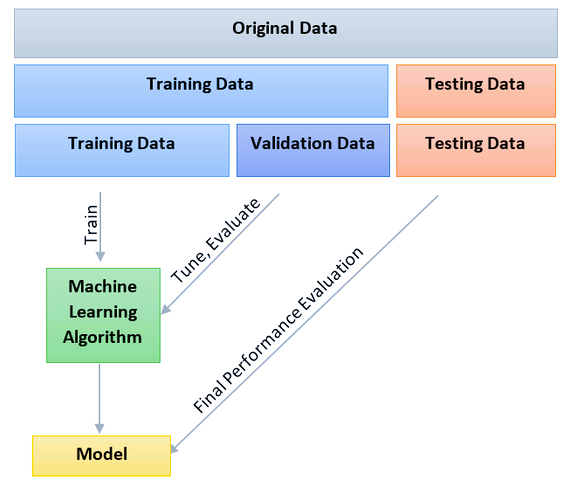


----
La clase *ImageDataGenerator* permite instanciar generadores de lotes de imágenes (y sus etiquetas) a partir de un directorio a través del método *flow_from_directory*. Estos generadores se puede usar con los métodos del modelo *Keras*.

*Parámetros:*


*   **Dirección:** se ingresa el path de donde están las imágenes.
*   **batch_size:** es el número de imágenes a procesar por lote.
*   **class_mode:** Indica el tipo de clasificación, en nuestro caso *categorical*.
*   **color_mode:** Indica el formato del color en el que deben estar las imágenes.
*   **target_size:** Especifica el tamaño al cual las imágenes serán redimensionadas sin importar su tamaño original.
*   **shuffle:** Indica si mezcla las imágenes para cada época.



Como las imágenes que se utilizarán para la validación pertenecen a la misma carpeta de entrenamiento, utilizamos el mismo generador indicando el porcentaje de datos que dejaremos para datos y luego a través de *subset* indicaremos que generador se usará para el entrenamiento y cual para validación.

In [11]:
train_datagen = ImageDataGenerator(rescale = 1.0/255., validation_split = 0.1)
test_datagen = ImageDataGenerator(rescale = 1.0/255. )

In [12]:
# Generadores de imágenes para el entrenamiento

# Todas las imágenes se pasan a Escala de grises
train_generator_gs = train_datagen.flow_from_directory(train_dir, batch_size=20,
                                                    class_mode='categorical',
                                                    color_mode='grayscale',
                                                    shuffle=True,
                                                    subset='training',
                                                    target_size=(56, 56))
# Todas las imágenes se pasan a RGB
train_generator_rgb = train_datagen.flow_from_directory(train_dir, batch_size=20,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    subset='training',
                                                    target_size=(56, 56))

# Generadores de imágenes para la validación

# Todas las imágenes se pasan a Escala de grises
validation_generator_gs = train_datagen.flow_from_directory(train_dir, batch_size=20,
                                                         class_mode='categorical',
                                                         color_mode='grayscale',
                                                         shuffle=True,
                                                         subset='validation',
                                                         target_size=(56, 56))
# Todas las imágenes se pasan a RGB
validation_generator_rgb = train_datagen.flow_from_directory(train_dir, batch_size=20,
                                                         class_mode='categorical',
                                                         color_mode='rgb',
                                                         shuffle=True,
                                                         subset='validation',
                                                         target_size=(56, 56))


# Generadores de imágenes para el testeo

# Todas las imágenes se pasan a Escala de grises
test_generator_gs = test_datagen.flow_from_directory(test_dir, batch_size=20,
                                                  color_mode='grayscale',
                                                  class_mode='categorical',
                                                  target_size=(56, 56))
# Todas las imágenes se pasan a RGB
test_generator_rgb = test_datagen.flow_from_directory(test_dir, batch_size=20,
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  target_size=(56, 56))


Found 5143 images belonging to 4 classes.
Found 5143 images belonging to 4 classes.
Found 569 images belonging to 4 classes.
Found 569 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Observamos las clases obtenidas en los tres generadores.

In [13]:
print("Train: ",train_generator_gs.class_indices)
print("Validation: ",validation_generator_gs.class_indices)
print("Test: ",test_generator_gs.class_indices)

Train:  {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Validation:  {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test:  {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Para entrenar un modelo de Keras se usa el método *fit*. Como primer parámetro se especifica el generador, y luego Keras necesita saber cuántas muestras extraer del generador antes de decidir que ha finalizado un *epoch*.

Por ello se calculo los pasos por epoch del entrenamiento y la validación. Proponemos utilizar un tamaño de batch fijo de 20.

In [14]:
batch_size = 20
steps_train = train_generator_rgb.n // batch_size             # número de imágenes de entrenamiento // 20 (div. entera)
steps_validation = validation_generator_rgb.n // batch_size   # número de imágenes de validación // 20 (div. entera)

print(steps_train)
print(steps_validation)

257
28


# Modelos de Redes Neuronales.

En esta sección se plantearán diferentes modelos de redes neuronales convolucionales. Cada modelo será analizado en base a su estructura y eficacia en la predicción.

Al final, se hará una breve conclusión de cual es el mejor modelo.


---
### *Primer Modelo (GS).*

El primer modelo a plantear, que llamaremos _Modelo Base (GS)_, será una red convolucional de tres capas:
1. **Primer capa convolucional:** 32 filtros, una ventana de 5x5, una entrada de 56x56x1 (tamaño de las imágenes) y una función de activación Relu.
2. **MaxPooling**: ventana de 2x2.
3. **Segunda capa convolucional:** 64 filtros, una ventana de 5x5 y  una función de activación Relu.
4. **Tercer capa:** capa densa de 4 categorias con activación Softmax.

Este modelo compilará con un optimizador *Stochastic Gradient Descent* (Realiza actualizaciones en cada iteración del entrenamiento utilizando un batch) y una función de pérdida "*Categorical Crossentropy*"(para problemas de clasificación multiclase con etiquetas como enteros).
Sobre este modelo base haremos modificaciones, que resultaran en nuevos modelos, con el fin de explorar y analizar qué es lo que cambia en cada caso.

In [ ]:
primer_modelo = Sequential(name='Modelo_Base_GS')

primer_modelo.add(Conv2D(32, (5, 5), activation='relu', input_shape=(56, 56, 1)))
primer_modelo.add(MaxPooling2D((2, 2)))
primer_modelo.add(Conv2D(64, (5, 5), activation='relu'))
primer_modelo.add(MaxPooling2D((2, 2)))
primer_modelo.add(Flatten())
primer_modelo.add(Dense(4, activation='softmax'))

primer_modelo.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
primer_modelo.summary()

Model: "Modelo_Base_GS"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 52, 52, 32)        832       
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 26, 26, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 22, 22, 64)        51264     
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 7744)              0         
                                                                 
 dense_24 (Dense)            (None, 4)              

In [ ]:
# Tiempo aproximado: 06:39.
begin = time.time()
primer_modelo.fit(train_generator_gs, steps_per_epoch = steps_train, epochs=10)
end = time.time()
time_primer_modelo = end - begin

257
Epoch 1/10
257/257 [==============================] - 36s 137ms/step - loss: 1.2033 - accuracy: 0.4277
Epoch 2/10
257/257 [==============================] - 36s 141ms/step - loss: 0.8465 - accuracy: 0.6844
Epoch 3/10
257/257 [==============================] - 38s 148ms/step - loss: 0.7154 - accuracy: 0.7330
Epoch 4/10
257/257 [==============================] - 40s 157ms/step - loss: 0.6261 - accuracy: 0.7642
Epoch 5/10
257/257 [==============================] - 40s 155ms/step - loss: 0.5637 - accuracy: 0.7882
Epoch 6/10
257/257 [==============================] - 37s 145ms/step - loss: 0.5135 - accuracy: 0.8095
Epoch 7/10
257/257 [==============================] - 40s 157ms/step - loss: 0.4663 - accuracy: 0.8259
Epoch 8/10
257/257 [==============================] - 40s 156ms/step - loss: 0.4399 - accuracy: 0.8321
Epoch 9/10
257/257 [==============================] - 38s 147ms/step - loss: 0.4169 - accuracy: 0.8507
Epoch 10/10
257/257 [==============================] - 42s 165ms/step

In [ ]:
test_loss, test_acc = primer_modelo.evaluate(test_generator_gs)
print('\nTest accuracy:', test_acc)

66/66 [==============================] - 3s 46ms/step - loss: 0.5109 - accuracy: 0.8078

Test accuracy: 0.8077803254127502


---
### *Primer Modelo bis (RGB).*

Es exáctamente igual al primer modelo con la diferencia de que, al estar todas las imágenes en formato RGB, recibirá como input el triple de parámetros (```input_size = (56,56,3)```). En contraste con el modelo anterior, se esperaría tener un tiempo de entrenamiento mayor a cambio de un aumento (no sabemos que tan grande) de la precisión. Esto último depende de algo que nosotros no conocemos, pero que los modelos basados en CNN pueden aprender: ¿qué es lo relevante en una MRI que hace que se pueda identificar si tiene algún tipo de tumor o no? Si el color juega un rol importante en esto, la diferencia en precisión podría ser demasiado grande para desestimarla. De lo contrario, optamos por la escala de grises y por ende por entrenamientos teóricamente más veloces.

In [ ]:
primer_modelo_bis = Sequential(name='Modelo_Base_GS')

primer_modelo_bis.add(Conv2D(32, (5, 5), activation='relu', input_shape=(56, 56, 3)))
primer_modelo_bis.add(MaxPooling2D((2, 2)))
primer_modelo_bis.add(Conv2D(64, (5, 5), activation='relu'))
primer_modelo_bis.add(MaxPooling2D((2, 2)))
primer_modelo_bis.add(Flatten())
primer_modelo_bis.add(Dense(4, activation='softmax'))

primer_modelo_bis.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
primer_modelo_bis.summary()  # Se observa que la cantidad de parámetros de entrada se triplicó

Model: "Modelo_Base_GS"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 52, 52, 32)        2432      
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 26, 26, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 22, 22, 64)        51264     
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_26 (Flatten)        (None, 7744)              0         
                                                                 
 dense_26 (Dense)            (None, 4)              

In [ ]:
# Tiempo aproximado: 06:25.
primer_modelo_bis.fit(train_generator_rgb, steps_per_epoch = steps_train, epochs=10)

Epoch 1/10
257/257 [==============================] - 41s 157ms/step - loss: 1.0989 - accuracy: 0.5204
Epoch 2/10
257/257 [==============================] - 41s 159ms/step - loss: 0.7352 - accuracy: 0.7259
Epoch 3/10
257/257 [==============================] - 41s 160ms/step - loss: 0.5951 - accuracy: 0.7820
Epoch 4/10
257/257 [==============================] - 41s 161ms/step - loss: 0.5183 - accuracy: 0.8109
Epoch 5/10
257/257 [==============================] - 40s 155ms/step - loss: 0.4747 - accuracy: 0.8274
Epoch 6/10
257/257 [==============================] - 40s 154ms/step - loss: 0.4349 - accuracy: 0.8417
Epoch 7/10
257/257 [==============================] - 39s 152ms/step - loss: 0.4022 - accuracy: 0.8544
Epoch 8/10
257/257 [==============================] - 39s 151ms/step - loss: 0.3734 - accuracy: 0.8643
Epoch 9/10
257/257 [==============================] - 40s 156ms/step - loss: 0.3524 - accuracy: 0.8759
Epoch 10/10
257/257 [==============================] - 40s 154ms/step - l

In [ ]:
test_loss, test_acc = primer_modelo_bis.evaluate(test_generator_rgb)
print('\nTest accuracy:', test_acc)

66/66 [==============================] - 5s 75ms/step - loss: 0.5712 - accuracy: 0.7849

Test accuracy: 0.7848970293998718


**Entonces... ¿RGB o escala de grises?**
- Contrario a lo que esperabamos, pasar todas las imágenes a escala de grises no redujo para nada el tiempo de entrenamiento (ambos modelos tardaron aproximadamente 6 minutos y medio). Suponemos que esto podría tener que ver con las arquitecturas subyacentes de las capas empleadas.
- Otra explicación que se nos ocurrió para explicar este fenómeno es que si en la proporción de imágenes RGB supera con creces a las imágenes en grayscale, es posible que las conversiones a grayscale terminen ocupando más tiempo del que se gana al disminuir la cantidad de parámetros que recibe el modelo.
- El grado de precisión fue más alto en el modelo que convierte las imágenes a RGB. En comparación obtuvimos:
  1. Escala de grises: Training_Acc = 0.8528; Testing_Acc = 0.8079;
  2. RGB: Training_Acc = 0.8811; Testing_Acc = 0.8276;
- A luz de los resultados, en los modelos siguientes la conversión se hace a RGB.


**Análisis de funcionamiento:**

El modelo predice con un porcentaje alrededor del 82% en las imágenes de testeo, lo cual no es tan malo. Aun así el porcentaje de acierto en el entrenamiento es sustancialmente mayor(88%) lo cual indica que puede llegar a haber un *sobreajuste*.  

---
### *Segundo Modelo.*

El segundo modelo que se plantea tiene la misma estructura que el primero, con la diferencia de que a este se le brindarán imágenes de validación y se le aplicará la técnica _Early Stopping_.

Las imágenes de validación se utilizan para evaluar el rendimiento del modelo en datos no vistos durante el entrenamiento. Para evitar el problema del sobreajuste que sucedia previamente se utilizará la técnica de "*Early Stopping*", donde el entrenamiento se detiene si la pérdida de validación no mejora durante un determinado número de épocas.

In [ ]:
segundo_modelo = Sequential()

segundo_modelo.add(Conv2D(32, (5, 5), activation='relu', input_shape=(56, 56, 3)))
segundo_modelo.add(MaxPooling2D((2, 2)))
segundo_modelo.add(Conv2D(64, (5, 5), activation='relu'))
segundo_modelo.add(MaxPooling2D((2, 2)))

segundo_modelo.add(Flatten())
segundo_modelo.add(Dense(4, activation='softmax'))

segundo_modelo.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
segundo_modelo.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 52, 52, 32)        2432      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 26, 26, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_57 (Conv2D)          (None, 22, 22, 64)        51264     
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_27 (Flatten)        (None, 7744)              0         
                                                                 
 dense_27 (Dense)            (None, 4)               

El callback "*EarlyStopping*" se usa durante el entrenamiento de un modelo para detener el entrenamiento de manera anticipada si una métrica específica no mejora después de un número determinado de épocas.

En nuestro caso se monitorea la perdida de validación. En caso que no mejore durante tres epocas el entrenamiento se detiene.

In [ ]:
callback = callbacks.EarlyStopping(monitor='val_loss',patience=3)
# Tiempo aproximado: 07:55.
historial_segundo_modelo = segundo_modelo.fit(train_generator_rgb, steps_per_epoch=steps_train, epochs=10,
                                              validation_data = validation_generator_rgb, validation_steps=steps_validation,
                                              callbacks=[callback])

Epoch 1/10
257/257 [==============================] - 52s 201ms/step - loss: 1.1142 - accuracy: 0.5069 - val_loss: 1.0762 - val_accuracy: 0.4411
Epoch 2/10
257/257 [==============================] - 41s 160ms/step - loss: 0.7604 - accuracy: 0.7187 - val_loss: 0.8840 - val_accuracy: 0.6286
Epoch 3/10
257/257 [==============================] - 42s 164ms/step - loss: 0.6173 - accuracy: 0.7728 - val_loss: 0.7577 - val_accuracy: 0.7482
Epoch 4/10
257/257 [==============================] - 42s 163ms/step - loss: 0.5375 - accuracy: 0.7995 - val_loss: 0.7758 - val_accuracy: 0.7179
Epoch 5/10
257/257 [==============================] - 41s 160ms/step - loss: 0.4801 - accuracy: 0.8243 - val_loss: 0.8092 - val_accuracy: 0.6768
Epoch 6/10
257/257 [==============================] - 41s 160ms/step - loss: 0.4339 - accuracy: 0.8477 - val_loss: 0.8205 - val_accuracy: 0.7125


In [ ]:
def visualizar_entrenamiento(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1,1)
  plt.plot(epochs, acc, 'g--', label='Accuracy entrenamiento')
  plt.plot(epochs, val_acc, 'r--', label='Accuracy validación')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'b--', label='Loss entrenamiento')
  plt.plot(epochs, val_loss, 'c--', label='Loss validación')
  plt.legend()
  plt.figure()

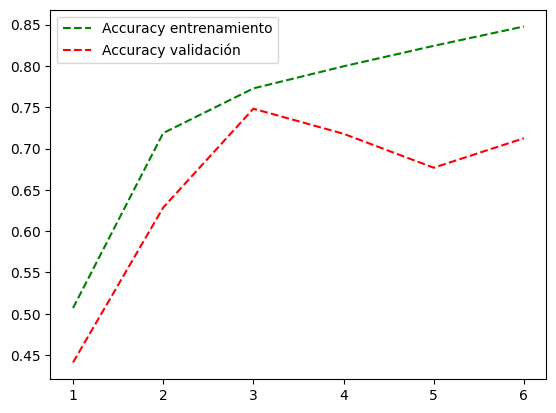

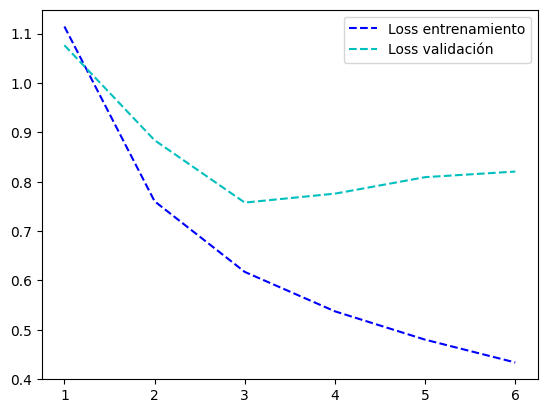

<Figure size 640x480 with 0 Axes>

In [ ]:
visualizar_entrenamiento(historial_segundo_modelo)

In [ ]:
test_loss, test_acc = segundo_modelo.evaluate(test_generator_rgb)
print('\nTest accuracy:', test_acc)

66/66 [==============================] - 5s 75ms/step - loss: 0.6011 - accuracy: 0.7704

Test accuracy: 0.7704042792320251


**Análisis:**

Como se puede apreciar gracias al método *early stopping* el entrenamiento se detuvo antes de los diez epoch, ya que la mejora del valor de perdida de los datos de validación convergio.

Si vemos en las gráficas, el *loss* de entrenamiento disminuye constantemente, pero no lo hace de la misma manera el loss de validación, ni la presición de validación, que alcanzan el punto máximo en la sexta epoch.

Nuevamente el valor de presición en el testing es similar al que obtuvimos en el anterio modelo(79%), y viendo las gráficas notamos que seguimos teniendo el problema del *sobreajuste*.

### *Tercer Modelo*
Los resultados obtenidos previamente son bastante buenos, pero nos gustaría mejorar la precisión.
En el siguiente modelo proponemos agregar una tercera capa convolucional a la estructura del segundo modelo.


In [ ]:
tercer_modelo = Sequential()

tercer_modelo.add(Conv2D(32, (5, 5), activation='relu', input_shape=(56, 56, 3)))
tercer_modelo.add(MaxPooling2D((2, 2)))
tercer_modelo.add(Conv2D(64, (5, 5), activation='relu'))
tercer_modelo.add(MaxPooling2D((2, 2)))
tercer_modelo.add(Conv2D(128, (5, 5), activation='relu'))
tercer_modelo.add(MaxPooling2D((2, 2)))

tercer_modelo.add(Flatten())
tercer_modelo.add(Dense(4, activation='softmax'))

tercer_modelo.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
tercer_modelo.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 52, 52, 32)        2432      
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 26, 26, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 22, 22, 64)        51264     
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 3, 3, 128)       

In [ ]:
callback = callbacks.EarlyStopping(monitor='val_loss',patience=3)
# Tiempo aproximado: 10:11.
historial_tercer_modelo = tercer_modelo.fit(train_generator_rgb, steps_per_epoch=steps_train, epochs=10,
                                              validation_data=validation_generator_rgb, validation_steps=steps_validation,
                                              callbacks=[callback])

Epoch 1/10
257/257 [==============================] - 46s 177ms/step - loss: 1.2726 - accuracy: 0.3754 - val_loss: 1.1742 - val_accuracy: 0.6446
Epoch 2/10
257/257 [==============================] - 44s 172ms/step - loss: 0.9825 - accuracy: 0.6623 - val_loss: 0.9857 - val_accuracy: 0.6393
Epoch 3/10
257/257 [==============================] - 45s 176ms/step - loss: 0.7693 - accuracy: 0.7267 - val_loss: 0.9561 - val_accuracy: 0.5857
Epoch 4/10
257/257 [==============================] - 44s 173ms/step - loss: 0.6503 - accuracy: 0.7619 - val_loss: 0.7590 - val_accuracy: 0.7375
Epoch 5/10
257/257 [==============================] - 46s 177ms/step - loss: 0.5724 - accuracy: 0.7915 - val_loss: 1.1758 - val_accuracy: 0.5250
Epoch 6/10
257/257 [==============================] - 51s 198ms/step - loss: 0.5182 - accuracy: 0.8064 - val_loss: 0.7411 - val_accuracy: 0.7232
Epoch 7/10
257/257 [==============================] - 46s 179ms/step - loss: 0.4494 - accuracy: 0.8323 - val_loss: 0.9925 - val_ac

In [ ]:
test_loss, test_acc = tercer_modelo.evaluate(test_generator_rgb)
print('\nTest accuracy:', test_acc)

66/66 [==============================] - 4s 57ms/step - loss: 0.4355 - accuracy: 0.8345

Test accuracy: 0.8344774842262268


**Análisis:**

El tercer modelo trae consigo un aumento considerable en el tiempo de entrenamiento debido al gran aumento en la cantidad de parámetros provocada por la inserción de una capa adicional, sin embargo su presición no aumentó casi nada con respecto a la de los modelos anteriores. En conclusión, en este caso una capa adicional (al menos con la configuración que propusimos) no implica una mejora en los resultados, sino que en líneas generales los empeora (relación precisión-tiempo).

### *Cuarto Modelo*

El cuarto modelo planteado retrocede al segundo modelo con la diferencia de que se agregan dos capas extras por cada capa convolucional: *Dropout* y *BatchNormalization*.
Estas dos son técnicas utilizadas en redes neuronales para mejorar el rendimiento del modelo y prevenir el sobreajuste. Específicamente:
*   *BatchNormalization*: Normaliza las entradas de la capa de manera que tengan una salida media de cero y una desviación estándar de uno. En general ayuda a estabilizar y acelerar el entrenamiento.
*   *Dropout*: Esta técnica se basa en "ignorar" temporalmente ciertos conjuntos de neuronas de la red durante la fase de entrenamiento de manera aleatoria con el fin de introducir ruido en el modelo y así evitar el sobreajuste.




In [31]:
cuarto_modelo = Sequential()

cuarto_modelo.add(Conv2D(32, (5, 5), activation='relu', input_shape=(56, 56, 3)))
cuarto_modelo.add(MaxPooling2D((2, 2)))
cuarto_modelo.add(BatchNormalization())
cuarto_modelo.add(Dropout(0.25))

cuarto_modelo.add(Conv2D(64, (5, 5), activation='relu'))
cuarto_modelo.add(MaxPooling2D((2, 2)))
cuarto_modelo.add(BatchNormalization())
cuarto_modelo.add(Dropout(0.25))

cuarto_modelo.add(Flatten())
cuarto_modelo.add(Dense(4, activation='softmax'))

cuarto_modelo.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
callback = callbacks.EarlyStopping(monitor='val_loss',patience=3)

begin = time.time()
historial_cuarto_modelo = cuarto_modelo.fit(train_generator_rgb, steps_per_epoch=steps_train, epochs=10,
                                              validation_data = validation_generator_rgb, validation_steps=steps_validation,
                                              callbacks=[callback])
end = time.time()

Epoch 1/10
257/257 [==============================] - 46s 174ms/step - loss: 1.0474 - accuracy: 0.7298 - val_loss: 2.0415 - val_accuracy: 0.4804
Epoch 2/10
257/257 [==============================] - 45s 173ms/step - loss: 0.6271 - accuracy: 0.8257 - val_loss: 1.3156 - val_accuracy: 0.6554
Epoch 3/10
257/257 [==============================] - 48s 186ms/step - loss: 0.4304 - accuracy: 0.8718 - val_loss: 1.0628 - val_accuracy: 0.7625
Epoch 4/10
257/257 [==============================] - 44s 173ms/step - loss: 0.3628 - accuracy: 0.8866 - val_loss: 1.0601 - val_accuracy: 0.7571
Epoch 5/10
257/257 [==============================] - 44s 173ms/step - loss: 0.2885 - accuracy: 0.9049 - val_loss: 0.9261 - val_accuracy: 0.7786
Epoch 6/10
257/257 [==============================] - 45s 173ms/step - loss: 0.2610 - accuracy: 0.9151 - val_loss: 1.0548 - val_accuracy: 0.7179
Epoch 7/10
257/257 [==============================] - 50s 196ms/step - loss: 0.1952 - accuracy: 0.9288 - val_loss: 0.8785 - val_ac

In [20]:
time_cuarto_modelo = (end - begin)
print('Tiempo: ',round(time_cuarto_modelo,2),'seg.') # en segundos

Tiempo:  500.44 seg.


In [21]:
test_loss, test_acc = cuarto_modelo.evaluate(test_generator_rgb)
print('\nTest accuracy:', test_acc)

66/66 [==============================] - 4s 60ms/step - loss: 0.4475 - accuracy: 0.8787

Test accuracy: 0.8787185549736023


**Análisis:**

Observando los datos del entrenamiento concluimos en que este modelo es el que mejor desempeño a tenido hasta el momento. A pesar de tardar un poco más que los primeros, lo compensa con una precisión notoriamente alta de aproximadamente 0.73 en la primera época, que continúa mejorando hasta que converge por Early Stopping tras tres épocas de mantenerse constante la pérdida. El entrenamiento generalmente termina en la época 8 con una precisión final aproximada de 0.95 (el corte temprano puede variar de entrenamiento a entrenamiento, incluso puede no ocurrir). Asimismo la precisión en testing es la más alta hasta el momento con un valor entre 0.88 y 0.90, dependiendo del entrenamiento.

---
### Quinto Modelo

Para este modelo decidimos partir desde el anterior, cuyo rendimiento es muy bueno, porque quisimos comprobar qué sucedía al modificar el tamaño de ventana de los filtros de las capas convolucionales. En vez de emplear filtros de 5x5, aumentamos el tamaño a 8x8. Esperaríamos obtener una mejora en la precisión a cambio de un aumento en la cantidad de cálculos (y por ende un aumento del tiempo de entrenamiento). ¿Por qué creemos que un filtro más grande podría producir mejores resultados? Porque un filtro más grande sencillamente abarca un área más amplia de la imagen de entrada, y esto permite capturar características más grandes y complejas en la imagen. Sin embargo es importante poder balancear el tamaño de los filtros ya que filtros demasiado grandes podrían hacer que se pierda granularidad sobre los detalles.


In [22]:
quinto_modelo = Sequential()

quinto_modelo.add(Conv2D(32, (8, 8), activation='relu', input_shape=(56, 56, 3)))
quinto_modelo.add(MaxPooling2D((2, 2)))
quinto_modelo.add(BatchNormalization())
quinto_modelo.add(Dropout(0.25))

quinto_modelo.add(Conv2D(64, (8, 8), activation='relu'))
quinto_modelo.add(MaxPooling2D((2, 2)))
quinto_modelo.add(BatchNormalization())
quinto_modelo.add(Dropout(0.25))

quinto_modelo.add(Flatten())
quinto_modelo.add(Dense(4, activation='softmax'))

quinto_modelo.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
callback = callbacks.EarlyStopping(monitor='val_loss',patience=3)

begin = time.time()
historial_quinto_modelo = quinto_modelo.fit(train_generator_rgb, steps_per_epoch=steps_train, epochs=10,
                                              validation_data=validation_generator_rgb, validation_steps=steps_validation,
                                              callbacks=[callback])
end = time.time()

Epoch 1/10
257/257 [==============================] - 71s 273ms/step - loss: 0.8920 - accuracy: 0.7318 - val_loss: 1.0840 - val_accuracy: 0.5625
Epoch 2/10
257/257 [==============================] - 70s 273ms/step - loss: 0.5019 - accuracy: 0.8354 - val_loss: 0.9701 - val_accuracy: 0.7018
Epoch 3/10
257/257 [==============================] - 70s 273ms/step - loss: 0.3829 - accuracy: 0.8766 - val_loss: 0.9754 - val_accuracy: 0.7464
Epoch 4/10
257/257 [==============================] - 70s 271ms/step - loss: 0.2910 - accuracy: 0.9018 - val_loss: 0.7075 - val_accuracy: 0.7732
Epoch 5/10
257/257 [==============================] - 74s 290ms/step - loss: 0.2376 - accuracy: 0.9151 - val_loss: 0.7008 - val_accuracy: 0.8089
Epoch 6/10
257/257 [==============================] - 77s 301ms/step - loss: 0.2354 - accuracy: 0.9155 - val_loss: 0.7111 - val_accuracy: 0.7982
Epoch 7/10
257/257 [==============================] - 74s 290ms/step - loss: 0.1797 - accuracy: 0.9375 - val_loss: 0.7265 - val_ac

In [24]:
time_quinto_modelo = (end - begin)
print('Tiempo: ',round(time_quinto_modelo,2),'seg.') # en segundos

Tiempo:  633.21 seg.


In [25]:
test_loss, test_acc = quinto_modelo.evaluate(test_generator_rgb)
print('\nTest accuracy:', test_acc)

66/66 [==============================] - 5s 72ms/step - loss: 0.5295 - accuracy: 0.8436

Test accuracy: 0.8436307907104492


**Análisis:**

Este modelo es el que más tardó en entrenarse. Si bien los resultados son relativamente buenos, no sucedió lo que esperabamos: el modelo anterior sigue siendo mejor. El aumento considerable en el tiempo de entrenamiento a cambio de obtener casi los mismos resultados, e incluso un poco peores, nos lleva a concluir en que este modelo no es viable. La pregunta es por qué.\
En este punto ya aprendimos la lección de que en redes neuronales rara vez _más cálculos_ se traduce en _mejores resultados_. Lo que puede haber ocurrido es que cuando se analizan imágenes de este tipo la clave para la clasificación esté en el detalle, por ende un filtro mayor, que contempla áreas más grandes de la imágen, pierde información valiosa que sirve para concluir correctamente sobre las imágenes. \
Por otro lado, si conociendo ahora esta información nos sintiéramos tentados a reducir el tamaño de los filtros podríamos entonces encontrarnos nuevamente con el problema opuesto: el sobreajuste. En el siguiente modelo probamos achicar la ventana para ver qué es lo que sucede.

### Sexto Modelo.

Al igual que el modelo anterior, partimos del cuarto modelo (el mejor hasta ahora) modificando únicamente el tamaño de la ventana de los filtros. En vez de 5x5 emplearemos una ventana de 2x2. Como ya mencionamos, podría ocurrir que el modelo mejore en precisión y tarde menos en entrenarse como podría ocurrir que empeore a causa del sobreajuste (demasiado énfasis sobre el detalle o ruido de las imágenes).

In [26]:
sexto_modelo = Sequential()

sexto_modelo.add(Conv2D(32, (2, 2), activation='relu', input_shape=(56, 56, 3)))
sexto_modelo.add(MaxPooling2D((2, 2)))
sexto_modelo.add(BatchNormalization())
sexto_modelo.add(Dropout(0.25))

sexto_modelo.add(Conv2D(64, (2, 2), activation='relu'))
sexto_modelo.add(MaxPooling2D((2, 2)))
sexto_modelo.add(BatchNormalization())
sexto_modelo.add(Dropout(0.25))

sexto_modelo.add(Flatten())
sexto_modelo.add(Dense(4, activation='softmax'))

sexto_modelo.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
callback = callbacks.EarlyStopping(monitor='val_loss',patience=3)
# Tiempo estimado: 08:06.
begin = time.time()
historial_sexto_modelo = sexto_modelo.fit(train_generator_rgb, steps_per_epoch=steps_train, epochs=10,
                                              validation_data=validation_generator_rgb, validation_steps=steps_validation,
                                              callbacks=[callback])
end = time.time()

Epoch 1/10
257/257 [==============================] - 28s 106ms/step - loss: 1.0665 - accuracy: 0.7419 - val_loss: 7.6021 - val_accuracy: 0.2554
Epoch 2/10
257/257 [==============================] - 29s 112ms/step - loss: 0.6556 - accuracy: 0.8224 - val_loss: 2.7168 - val_accuracy: 0.4429
Epoch 3/10
257/257 [==============================] - 33s 129ms/step - loss: 0.5031 - accuracy: 0.8530 - val_loss: 2.6803 - val_accuracy: 0.5429
Epoch 4/10
257/257 [==============================] - 31s 120ms/step - loss: 0.4163 - accuracy: 0.8807 - val_loss: 1.8418 - val_accuracy: 0.6464
Epoch 5/10
257/257 [==============================] - 31s 119ms/step - loss: 0.3450 - accuracy: 0.8897 - val_loss: 1.6680 - val_accuracy: 0.6625
Epoch 6/10
257/257 [==============================] - 32s 123ms/step - loss: 0.2723 - accuracy: 0.9157 - val_loss: 1.5264 - val_accuracy: 0.6750
Epoch 7/10
257/257 [==============================] - 34s 132ms/step - loss: 0.2262 - accuracy: 0.9223 - val_loss: 1.2255 - val_ac

In [28]:
time_sexto_modelo = end - begin
print('Tiempo: ',round(time_sexto_modelo,2),'seg.') # en segundos

Tiempo:  311.55 seg.


In [29]:
test_loss, test_acc = sexto_modelo.evaluate(test_generator_rgb)
print('\nTest accuracy:', test_acc)

66/66 [==============================] - 4s 67ms/step - loss: 0.8310 - accuracy: 0.8078

Test accuracy: 0.8077803254127502


**_¿Qué tanta atención al detalle debería emplearse entonces?_** \
Según los resultados obtenidos tras probar qué ocurre cuando modificamos el tamaño de la ventana en +3 y -3, concluímos en que la ventana de 5x5 (modelo 4) es la más cercana a la ideal porque es la que arroja mejores resultados, y lo hace en un tiempo aceptable. Como ya hemos implementado demasiados modelos preferimos no añadir más, pero quisimos hacer énfasis en la dificultad que se presenta al querer dar con los valores idóneos para los parámetros del entrenamiento de los modelos. Comprobamos que muchas veces efectivamente se trata de prueba y error.
A continuación graficamos los entrenamientos de los modelos cuatro, cinco y seis junto con sus respectivos tiempos para comparar su desempeño.

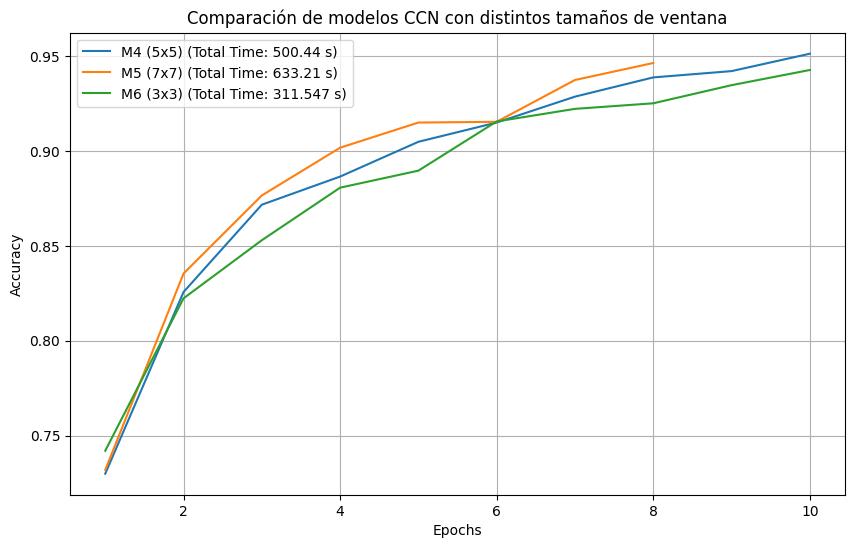

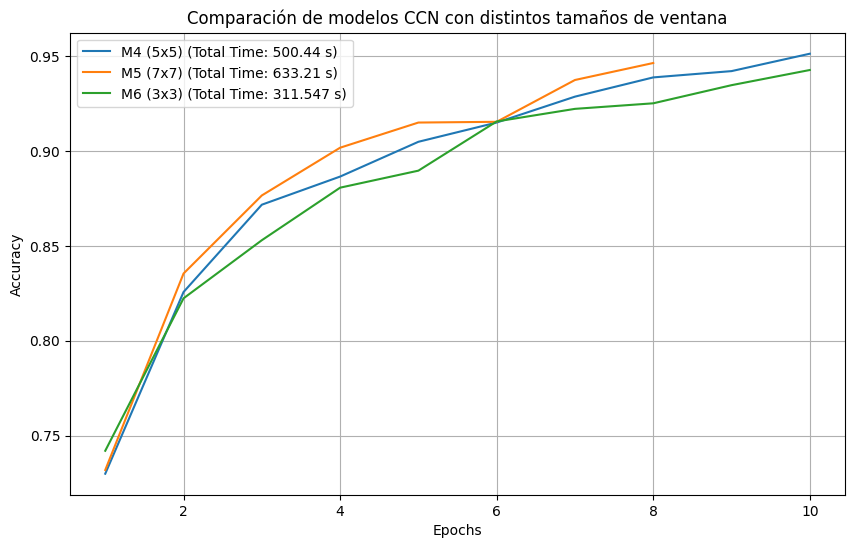

In [33]:
plt.figure(figsize=(10, 6))

hist_m4 = historial_cuarto_modelo.history['accuracy']
hist_m5 = historial_quinto_modelo.history['accuracy']
hist_m6 = historial_sexto_modelo.history['accuracy']

plt.plot(range(1,len(hist_m4)+1), hist_m4, label=f'M4 (5x5) (Total Time: {round(time_cuarto_modelo,3)} s)')
plt.plot(range(1,len(hist_m5)+1), hist_m5, label=f'M5 (7x7) (Total Time: {round(time_quinto_modelo,3)} s)')
plt.plot(range(1,len(hist_m6)+1), hist_m6, label=f'M6 (3x3) (Total Time: {round(time_sexto_modelo,3)} s)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparación de modelos CCN con distintos tamaños de ventana')
plt.legend()
plt.grid(True)
plt.show()

**Análisis:**

En terminos de costo y beneficio podemos concluir que el *cuarto modelo* sigue siendo el mejor.

Una **observación** que podemos realizar es que los reslutados de *accuracy* varian al momento en que uno vuelve a entrenar la red desde cero, debido a que las imágenes que se ingresan a la red durante el entrenamiento lo hacen de manera aleatoria, lo que genera que los resultados puedan variar un poco.

### Septimo Modelo

El septimo modelo que se plantea parte de la estructura del *cuarto modelo* y agrega una capa densa de 128 neuronas con activación relu.

Al agregar una capa densa a la red neuronal estamos buscando mejorar la capacidad de moldear relaciones complejas entre los datos, generar un nuevo nivel de abstracción, y mejorar la generalización de datos no vistos.

In [ ]:
septimo_modelo = Sequential()

septimo_modelo.add(Conv2D(32, (5, 5), activation='relu', input_shape=(56, 56, 3)))
septimo_modelo.add(MaxPooling2D((2, 2)))
septimo_modelo.add(BatchNormalization())
septimo_modelo.add(Dropout(0.25))

septimo_modelo.add(Conv2D(64, (5, 5), activation='relu'))
septimo_modelo.add(MaxPooling2D((2, 2)))
septimo_modelo.add(BatchNormalization())
septimo_modelo.add(Dropout(0.25))

septimo_modelo.add(Flatten())
septimo_modelo.add(Dense(128, activation='relu'))
septimo_modelo.add(Dense(4, activation='softmax'))

septimo_modelo.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callback = callbacks.EarlyStopping(monitor='val_loss',patience=3)

begin = time.time()
historial_septimo_modelo = septimo_modelo.fit(train_generator_rgb, steps_per_epoch=steps_train, epochs=10,
                                              validation_data=validation_generator_rgb, validation_steps=steps_validation,
                                              callbacks=[callback])
end = time.time()

Epoch 1/10
257/257 [==============================] - 52s 199ms/step - loss: 0.5691 - accuracy: 0.7804 - val_loss: 2.7722 - val_accuracy: 0.3214
Epoch 2/10
257/257 [==============================] - 52s 202ms/step - loss: 0.3329 - accuracy: 0.8751 - val_loss: 1.2918 - val_accuracy: 0.6000
Epoch 3/10
257/257 [==============================] - 57s 221ms/step - loss: 0.2538 - accuracy: 0.8993 - val_loss: 0.5692 - val_accuracy: 0.8125
Epoch 4/10
257/257 [==============================] - 56s 218ms/step - loss: 0.1914 - accuracy: 0.9303 - val_loss: 0.5112 - val_accuracy: 0.8357
Epoch 5/10
257/257 [==============================] - 53s 207ms/step - loss: 0.1419 - accuracy: 0.9494 - val_loss: 0.5975 - val_accuracy: 0.8339
Epoch 6/10
257/257 [==============================] - 58s 225ms/step - loss: 0.1096 - accuracy: 0.9623 - val_loss: 0.6827 - val_accuracy: 0.8054
Epoch 7/10
257/257 [==============================] - 46s 177ms/step - loss: 0.0865 - accuracy: 0.9711 - val_loss: 0.6677 - val_ac

In [ ]:
time_septimo_modelo = end - begin
print('Tiempo: ',round(time_septimo_modelo,2),'seg.') # en segundos

759.4846413135529


In [ ]:
test_loss, test_acc = septimo_modelo.evaluate(test_generator_rgb)
print('\nTest accuracy:', test_acc)

66/66 [==============================] - 4s 58ms/step - loss: 0.2227 - accuracy: 0.9138

Test accuracy: 0.9138062596321106


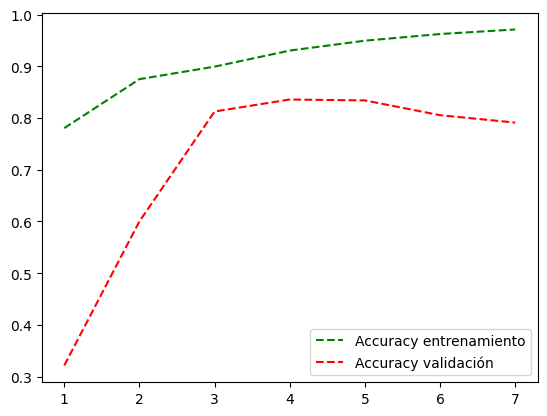

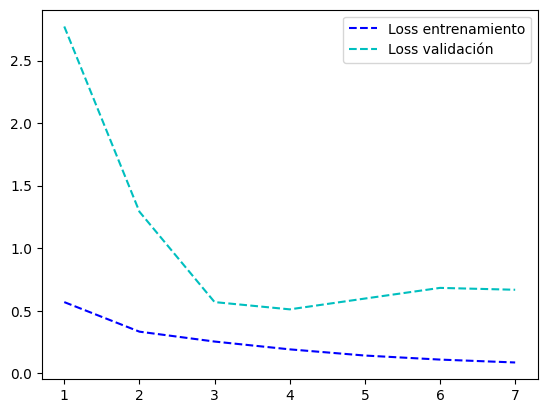

<Figure size 640x480 with 0 Axes>

In [ ]:
visualizar_entrenamiento(historial_septimo_modelo)

**Análisis:**

Esta modificación aumentó considerablemente la precisión del modelo, que ronda un 97% de aciertos. El séptimo modelo supera al cuarto en performance y en tiempo de entrenamiento. \
A luz de los resultados obtenidos en el séptimo modelo podemos observar que el rendimiento en el entrenamiento mejora de manera sustancial y la precisión en el testeo aumenta.
A pesar de que la diferencia entre el *accuracy de entrenamiento* y el *accuracy de testeo* sea un poco alta, la precisión es tan alta que puede decirse que el modelo funciona correctamente.

### **Conclusiones.**

No hay una forma precisa o una guía de pasos exácta para crear un modelo de redes neuronales, es un proceso que termina siendo prueba y error. Sin embargo si se tiene conocimiento en las distintas maneras de preparar y normalizar los datos, en como entrenar a una red y en qué implementar para intenar que mejore su precisión podemos llegar a resultados más que satisfactorios.

En nuestro caso buscamos mejorar los distintos modelos intentando evitar el sobreentrenamiento y ajustando los modelos a través de la cantidad de capas y el tamaño de los filtros. Así obtuvimos una versión que predice de manera muy precisa imágenes que nunca habia visto.
Por esto mismo concluimos que a partir del septimo modelo ya podemos comenzar a implementar la técnica de data augmentation.

En el caso de que un modelo no funcione correctamente otras moficaciones que se le podrían implementar, a parte de las vistas en el trabajo, son:

*   *Epoch*: Aumentar el número de epocas para que el entrenamiento se más extenso.
*   *Optimizador*: Buscar otro optimizador que se adecue al problema.
*   *Número de filtros*: Aumentar o disminuir el número de filtros.
*   *Padding*: Si los bordes de la imagen son importantes, agregar un padding podría ser util.

# Data Augmentation

Data augmentation es una técnica utilizada para aumentar la cantidad de datos para el entrenamiento. Se adopta el enfoque de generar más datos de entrenamiento a partir de nuestros datos disponibles. En el caso de las imágenes, se consigue aplicando una serie de transformaciones.

Para nuestro caso de estudio partimos de la estructura del mejor modelo creado(*séptimo modelo*) y lo entrenamos con los datos aumentados y los originales, para luego observar la mejora obtenida.

A través de la clase *imageGenerator*, mencionada anteriormente, tomamos las imágenes de entrenamiento y les aplicamos una transformación con los parámetros:

*   **rotation_range:** Rota la imagen de manera aleatoria en un número determinado de grados.
*   **horizontal_flip:** permite voltear una imagen de manera horizontal.
*   **vertical_flip:** permite voltear una imagen de manera vertical.
*   **fill_mode nearest:** rellena los píxeles recién creados que pueden aparecer después de una de las transformaciones.

In [ ]:
train_datagen_DA = ImageDataGenerator(rescale = 1./255, rotation_range=40, horizontal_flip=True, vertical_flip=True,
                                      fill_mode='nearest',
                                      validation_split=0.2)


In [ ]:
train_generator_DA = train_datagen_DA.flow_from_directory(train_dir, batch_size=20,
                                                          class_mode='categorical',
                                                          shuffle=True,
                                                          subset='training',
                                                          color_mode='rgb',
                                                          target_size=(56, 56)
                                                          )

validation_generator_DA = train_datagen_DA.flow_from_directory(train_dir, batch_size=20,
                                                               class_mode='categorical',
                                                               shuffle=True,
                                                               color_mode='rgb',
                                                               subset='validation',
                                                               target_size=(56, 56))


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [ ]:
batch_size = 20
steps_train_DA = train_generator_DA.n // batch_size

steps_validation_DA = validation_generator_DA.n // batch_size

print(steps_train_DA)
print(steps_validation_DA)

228
57


In [ ]:
modelo_final = Sequential()


modelo_final.add(Conv2D(32, (5, 5), activation='relu', input_shape=(56, 56, 3)))
modelo_final.add(MaxPooling2D((2, 2)))
modelo_final.add(BatchNormalization())
modelo_final.add(Dropout(0.25))

modelo_final.add(Conv2D(64, (5, 5), activation='relu'))
modelo_final.add(MaxPooling2D((2, 2)))
modelo_final.add(BatchNormalization())
modelo_final.add(Dropout(0.25))

modelo_final.add(Flatten())
modelo_final.add(Dense(128, activation='relu'))
modelo_final.add(Dense(4, activation='softmax'))

modelo_final.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callback = callbacks.EarlyStopping(monitor='val_loss',patience=3)

begin = time.time()

historial_modelo_final = modelo_final.fit(train_generator_DA, steps_per_epoch=steps_train_DA, epochs=10,
                                              validation_data=validation_generator_DA, validation_steps=steps_validation_DA,
                                              callbacks=[callback])

end = time.time()

Epoch 1/10
228/228 [==============================] - 56s 241ms/step - loss: 0.8248 - accuracy: 0.6869 - val_loss: 2.4833 - val_accuracy: 0.3167
Epoch 2/10
228/228 [==============================] - 61s 268ms/step - loss: 0.5817 - accuracy: 0.7660 - val_loss: 1.2200 - val_accuracy: 0.5728
Epoch 3/10
228/228 [==============================] - 54s 239ms/step - loss: 0.5064 - accuracy: 0.7965 - val_loss: 0.8050 - val_accuracy: 0.7316
Epoch 4/10
228/228 [==============================] - 56s 246ms/step - loss: 0.4619 - accuracy: 0.8137 - val_loss: 0.8899 - val_accuracy: 0.6833
Epoch 5/10
228/228 [==============================] - 57s 250ms/step - loss: 0.4381 - accuracy: 0.8260 - val_loss: 0.7268 - val_accuracy: 0.7518
Epoch 6/10
228/228 [==============================] - 57s 248ms/step - loss: 0.4206 - accuracy: 0.8240 - val_loss: 0.8998 - val_accuracy: 0.7281
Epoch 7/10
228/228 [==============================] - 57s 250ms/step - loss: 0.3952 - accuracy: 0.8370 - val_loss: 0.7898 - val_ac

In [ ]:
time_modelo_final = end - begin
print(time_modelo_final)

759.4846413135529


In [ ]:
test_loss, test_acc = modelo_final.evaluate(test_generator_rgb)
print('\nTest accuracy:', test_acc)

66/66 [==============================] - 4s 58ms/step - loss: 0.6728 - accuracy: 0.7666

Test accuracy: 0.766590416431427


**Análisis preliminar:**

El modelo que mejor funcionamiento tuvo en la anterior sección, fue entrenado desde cero solo con datos aumentados y esto arroja resultados no muy favorables, ni para el entrenamiento ni para el testeo. Pero aun así veamos como se desenvuelve cuando es reentrenado con los datos originales.

In [ ]:
begin = time.time()
historial_modelo_final = modelo_final.fit(train_generator_rgb, steps_per_epoch=steps_train, epochs=10,
                                              validation_data=validation_generator_rgb, validation_steps=steps_validation,
                                              callbacks=[callback])

end = time.time()

Epoch 1/10
257/257 [==============================] - 45s 174ms/step - loss: 0.2971 - accuracy: 0.8872 - val_loss: 0.5209 - val_accuracy: 0.8393
Epoch 2/10
257/257 [==============================] - 45s 176ms/step - loss: 0.2097 - accuracy: 0.9247 - val_loss: 0.6780 - val_accuracy: 0.7589
Epoch 3/10
257/257 [==============================] - 44s 171ms/step - loss: 0.1647 - accuracy: 0.9391 - val_loss: 0.5993 - val_accuracy: 0.8214
Epoch 4/10
257/257 [==============================] - 44s 172ms/step - loss: 0.1201 - accuracy: 0.9592 - val_loss: 0.5204 - val_accuracy: 0.8161
Epoch 5/10
257/257 [==============================] - 48s 185ms/step - loss: 0.1041 - accuracy: 0.9619 - val_loss: 0.5807 - val_accuracy: 0.8196
Epoch 6/10
257/257 [==============================] - 44s 170ms/step - loss: 0.0817 - accuracy: 0.9721 - val_loss: 0.5441 - val_accuracy: 0.8464
Epoch 7/10
257/257 [==============================] - 44s 171ms/step - loss: 0.0712 - accuracy: 0.9760 - val_loss: 0.7018 - val_ac

In [ ]:
time_modelo_final = end - begin
print(time_modelo_final)

497.61240243911743


In [ ]:
test_loss, test_acc = modelo_final.evaluate(test_generator_rgb)
print('\nTest accuracy:', test_acc)

66/66 [==============================] - 4s 57ms/step - loss: 0.1773 - accuracy: 0.9397

Test accuracy: 0.9397406578063965


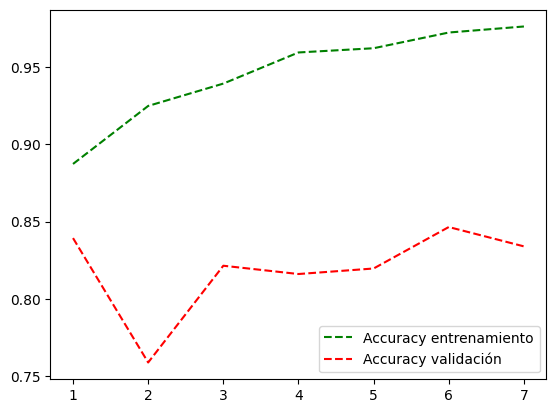

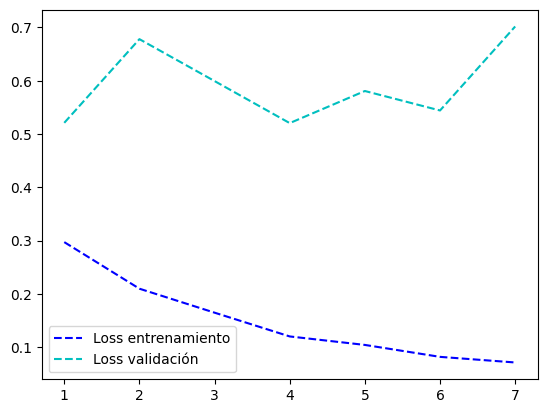

<Figure size 640x480 with 0 Axes>

In [ ]:
visualizar_entrenamiento(historial_modelo_final)

### **Conclusiones.**

En el caso de estudio aquí planteado, la técnica de data augmentation no aumenta en gran medida la precisión de entrenamiento, pero si logra aumentar la precisión en las imágenes de testeo.

En conclusión esta técnica es muy buena a la hora de tener pocos datos y ayuda a evitar en buena medida el sobreajuste.

### Predicción de tumores.

In [ ]:
def prediccion_imagen(modelo, dir_base, dir_fnames, indice,label,tamanio,cantidad):
    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    indice_inv = {valor:key for key, valor in indice.items()}

    for i in range(0,cantidad):
      j = np.random.randint(tamanio)

      sp = plt.subplot(4, 4, i + 1)
      path_img = os.path.join(dir_base, dir_fnames[j])

      img = image.load_img(path_img, target_size=(56, 56))


      img_reescala = image.img_to_array(img) / 255.0
      img_prueba = np.expand_dims(img_reescala, axis=0)

      prediction = modelo.predict(img_prueba)
      clase = np.argmax(prediction, axis=1)

      plt.xlabel("{} {:2.0f}%\n ({})".format(indice_inv[clase[0]],
                                100*np.max(prediction),
                                label))

      plt.imshow(img)

    plt.tight_layout()
    print("")
    print("Clase Original: "+label)
    plt.show()

1/1 [==============================] - 0s 34ms/step

Clase Original: Glioma


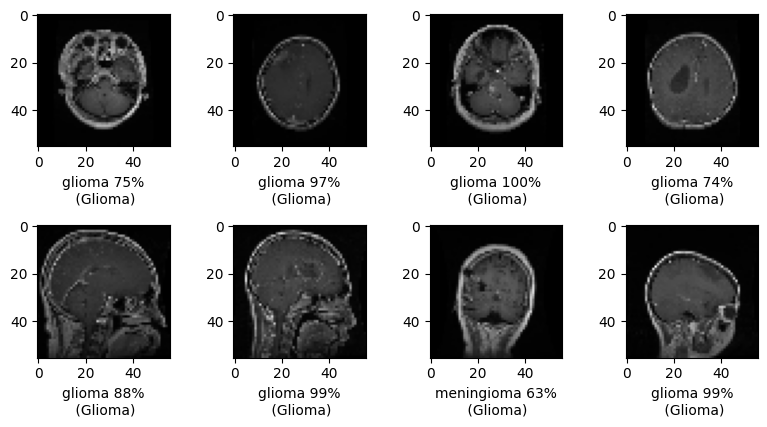


1/1 [==============================] - 0s 22ms/step

Clase Original: Meningioma


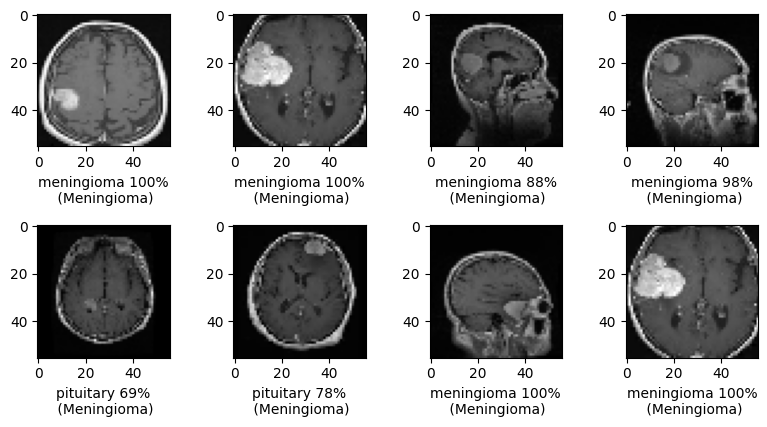


1/1 [==============================] - 0s 26ms/step

Clase Original: Pituitary


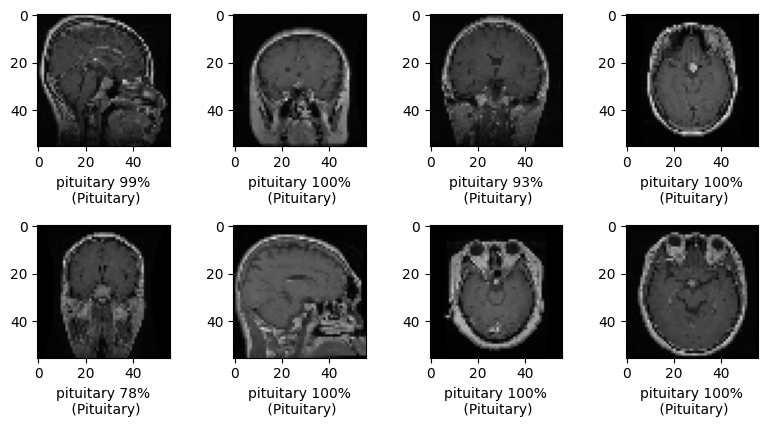


1/1 [==============================] - 0s 22ms/step

Clase Original: Notumor


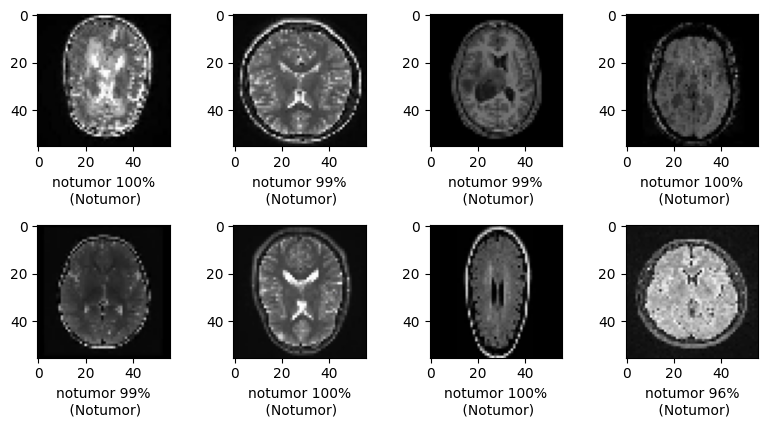

In [ ]:
prediccion_imagen(modelo_final,test_glioma,test_glioma_fnames,test_generator_rgb.class_indices,"Glioma",cant_test_glioma,8)
print("")
prediccion_imagen(modelo_final,test_meningioma,test_meningioma_fnames,test_generator_rgb.class_indices,"Meningioma",cant_test_meningioma,8)
print("")
prediccion_imagen(modelo_final,test_pituitary,test_pituitary_fnames,test_generator_rgb.class_indices,"Pituitary",cant_test_pituitary,8)
print("")
prediccion_imagen(modelo_final,test_notumor,test_notumor_fnames,test_generator_rgb.class_indices,"Notumor",cant_test_no_tumor,8)